In [2]:
!pip install tensorflow

In [46]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline

# For time stamps
from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

### Define Key Variables

In [49]:
train_split_percentage = 0.95
seq_length = 30 # for LSTM model

### Load Data

In [52]:
df_load = pd.read_csv('../data/Preprocessed_data/df_cleaned_01.csv')

In [54]:
# Set the 'Date' column back to the index
# Convert 'Date' column to datetime
df_load['Date'] = pd.to_datetime(df_load['Date'])
df_load.set_index('Date', inplace=True)

df_load.head(100)

,ticker_symbol,company_name,Open,High,Low,Close,Adj Close,Volume,Daily_Return,30_MA,90_MA,RSI,MACD,symbol,actualEarningResult,estimatedEarning
Date,,,,,,,,,,,,,,,,
2022-07-25,OCUL,OCUL,4.37,4.410,4.179,4.26,4.26,264400,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
2022-07-26,OCUL,OCUL,4.21,4.370,4.150,4.31,4.31,260500,0.011737,NaN,NaN,NaN,0.003989,NaN,NaN,NaN
2022-07-27,OCUL,OCUL,4.33,4.480,4.270,4.45,4.45,284800,0.032483,NaN,NaN,NaN,0.018236,NaN,NaN,NaN
2022-07-28,OCUL,OCUL,4.47,4.480,4.200,4.30,4.30,299900,-0.033708,NaN,NaN,NaN,0.017225,NaN,NaN,NaN
2022-07-29,OCUL,OCUL,4.32,4.485,4.190,4.48,4.48,511900,0.041860,NaN,NaN,NaN,0.030596,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-07,OCUL,OCUL,2.90,2.920,2.800,2.80,2.80,207000,-0.034483,3.191333,4.393389,36.458338,-0.198700,NaN,NaN,NaN
2022-12-08,OCUL,OCUL,2.81,2.880,2.735,2.76,2.76,409300,-0.014286,3.160333,4.374944,38.888890,-0.201888,NaN,NaN,NaN
2022-12-09,OCUL,OCUL,2.76,2.770,2.610,2.61,2.61,353600,-0.054348,3.130333,4.351833,32.038837,-0.214050,NaN,NaN,NaN


In [56]:
df_load.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1503 entries, 2022-07-25 to 2024-07-22
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ticker_symbol        1503 non-null   object 
 1   company_name         1503 non-null   object 
 2   Open                 1503 non-null   float64
 3   High                 1503 non-null   float64
 4   Low                  1503 non-null   float64
 5   Close                1503 non-null   float64
 6   Adj Close            1503 non-null   float64
 7   Volume               1503 non-null   int64  
 8   Daily_Return         1500 non-null   float64
 9   30_MA                1416 non-null   float64
 10  90_MA                1236 non-null   float64
 11  RSI                  1464 non-null   float64
 12  MACD                 1503 non-null   float64
 13  symbol               24 non-null     object 
 14  actualEarningResult  24 non-null     float64
 15  estimatedEarning    

In [58]:
# Dropping rows with null values for 90 day moving average, this should only clear the first ~90 days worth of data. 
df_load = df_load.dropna(subset=['90_MA'])
# Drop feature 'Symbol' dulplicate for ticker_symbol.
df_load = df_load.drop(columns = 'symbol')

In [60]:
df_load.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1236 entries, 2022-11-29 to 2024-07-22
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ticker_symbol        1236 non-null   object 
 1   company_name         1236 non-null   object 
 2   Open                 1236 non-null   float64
 3   High                 1236 non-null   float64
 4   Low                  1236 non-null   float64
 5   Close                1236 non-null   float64
 6   Adj Close            1236 non-null   float64
 7   Volume               1236 non-null   int64  
 8   Daily_Return         1236 non-null   float64
 9   30_MA                1236 non-null   float64
 10  90_MA                1236 non-null   float64
 11  RSI                  1236 non-null   float64
 12  MACD                 1236 non-null   float64
 13  actualEarningResult  18 non-null     float64
 14  estimatedEarning     18 non-null     float64
dtypes: float64(12), int6

In [62]:
missing_values_count = df_load['actualEarningResult'].isna().sum()
print(f"Number of missing values in 'actualEarningResult' column is: {missing_values_count}")

Number of missing values in 'actualEarningResult' column is: 1218


In [64]:
missing_values_count = df_load['estimatedEarning'].isna().sum()
print(f"Number of missing values in 'estimatedEarning' column is: {missing_values_count}")

Number of missing values in 'estimatedEarning' column is: 1218


In [66]:
df_load['actualEarningResult'] = df_load['actualEarningResult'].fillna(0)
df_load['estimatedEarning'] = df_load['estimatedEarning'].fillna(0)

In [68]:
missing_values_count = df_load['actualEarningResult'].isna().sum()
print(f"Number of missing values in 'actualEarningResult' column is: {missing_values_count}")

Number of missing values in 'actualEarningResult' column is: 0


In [70]:
missing_values_count = df_load['estimatedEarning'].isna().sum()
print(f"Number of missing values in 'estimatedEarning' column is: {missing_values_count}")

Number of missing values in 'estimatedEarning' column is: 0


### Pre-Processing Data:

In [73]:
# unzip df by stock and add it to a dictionary.
stock_data = {}
tech_list = df_load['ticker_symbol'].unique()
# Iterate over each unique ticker symbol in the DataFrame
for ticker in tech_list:
    # Filter the DataFrame for the current ticker symbol
    stock_df = df_load[df_load['ticker_symbol'] == ticker].copy()
    stock_df = stock_df[['ticker_symbol', 'company_name', 'Open', 'High', 'Low', 
       'Adj Close', 'Volume', 'Daily_Return', '30_MA', '90_MA', 'RSI', 'MACD',
       'actualEarningResult', 'estimatedEarning', 'Close']]
    # Store the DataFrame in the dictionary
    stock_data[ticker] = stock_df
    
# Display the DataFrame for a specific stock, e.g., 'OCUL'
stock_data['OCUL'].head()

,ticker_symbol,company_name,Open,High,Low,Adj Close,Volume,Daily_Return,30_MA,90_MA,RSI,MACD,actualEarningResult,estimatedEarning,Close
Date,,,,,,,,,,,,,,,
2022-11-29,OCUL,OCUL,2.89,2.93,2.81,2.87,606900,-0.010345,3.361667,4.485056,40.645155,-0.270333,0.0,0.0,2.87
2022-11-30,OCUL,OCUL,2.85,3.00,2.83,2.97,472400,0.034843,3.319333,4.470722,57.031253,-0.256027,0.0,0.0,2.97
2022-12-01,OCUL,OCUL,2.96,3.14,2.96,3.05,408900,0.026936,3.292000,4.456722,50.892856,-0.235518,0.0,0.0,3.05
2022-12-02,OCUL,OCUL,2.96,3.16,2.95,3.13,395600,0.026230,3.269667,4.442056,42.708341,-0.210385,0.0,0.0,3.13
2022-12-05,OCUL,OCUL,3.13,3.15,2.90,2.99,529600,-0.044728,3.246667,4.427500,33.653853,-0.199464,0.0,0.0,2.99


### Dummy Regressor: 

### Train/Test Split Data:

In [76]:
# fuction to split df into train and test.
def train_test_data(df):
    X = df
    y = df['Close']
     # Calculate the split index, split percentage defined up top in imports. 
    split_index = int(len(df) * train_split_percentage)
    
    # Split the data into training and test sets
    # IMPORTANT NOTE: Add a 1 row lag between X and Y. The goal is to predict next days Close Price using past data.
    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:-1]
    y_train = y.iloc[1:split_index+1]
    y_test = y.iloc[split_index+1:]
    
    return X_train, X_test, y_train, y_test

split_data = {}
for stock in tech_list:
    split_data[stock] = train_test_data(stock_data[stock])

In [78]:
# check to see shapes of train and test df and split correctly.
for i in range(4):
    print(split_data['OCUL'][i].shape)

(391, 15)
(20, 15)
(391,)
(20,)


In [80]:
# Dummy regression training model function
def train_dummy(X_train, y_train):
    dumb_reg = DummyRegressor(strategy='mean')
    dumb_reg.fit(X_train, y_train)
    return dumb_reg

trained_models = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test = split_data[stock]
    trained_models[stock] = train_dummy(X_train, y_train)

In [82]:
# Dummy regression evaluation model function. 
def evaluate_models(model, X_test, y_test):
    results = {}  
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    results = {'MAE': mae, 'RMSE': rmse}
    return results

evaluation_results = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test = split_data[stock]
    evaluation_results[stock] = evaluate_models(trained_models[stock], X_test, y_test)

for stock, results in evaluation_results.items():
    print(f"Evaluation results for {stock}:")
    print(f"MAE = {results['MAE']}, RMSE = {results['RMSE']}")

Evaluation results for OCUL:
MAE = 2.2094386309618925, RMSE = 2.311614980118595
Evaluation results for SLDB:
MAE = 1.1794322446873404, RMSE = 1.5579728360745835
Evaluation results for URGN:
MAE = 3.581244120936062, RMSE = 3.6499701310923536


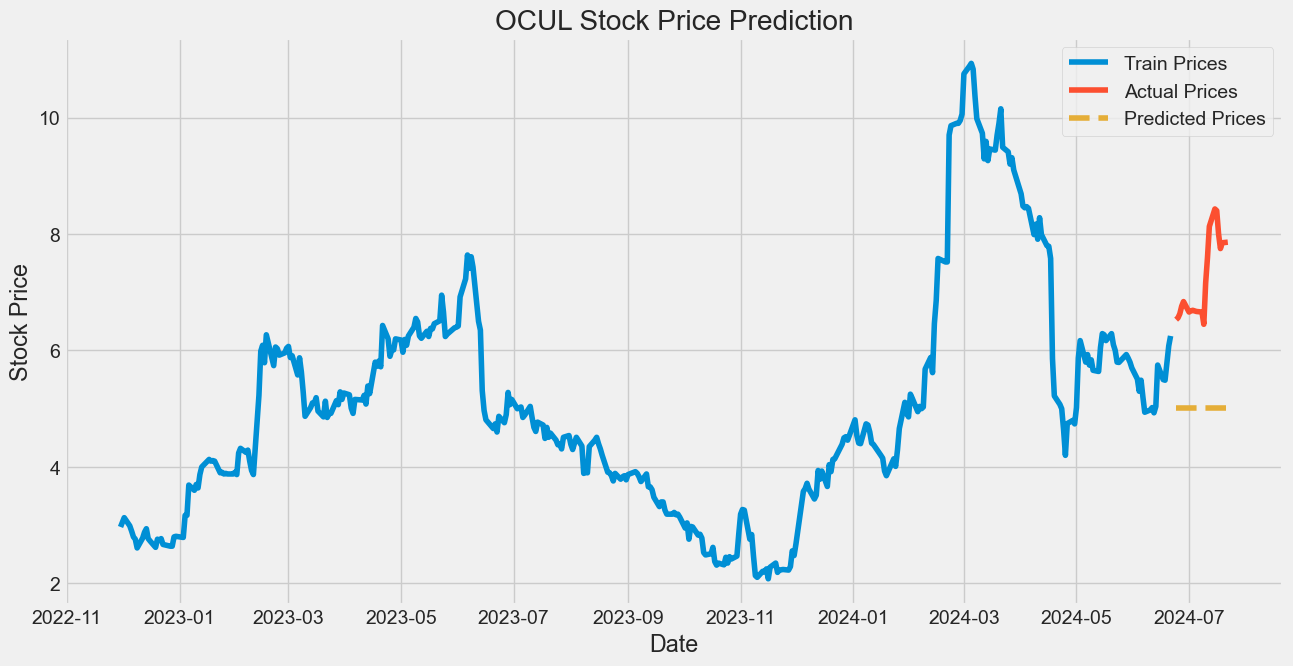

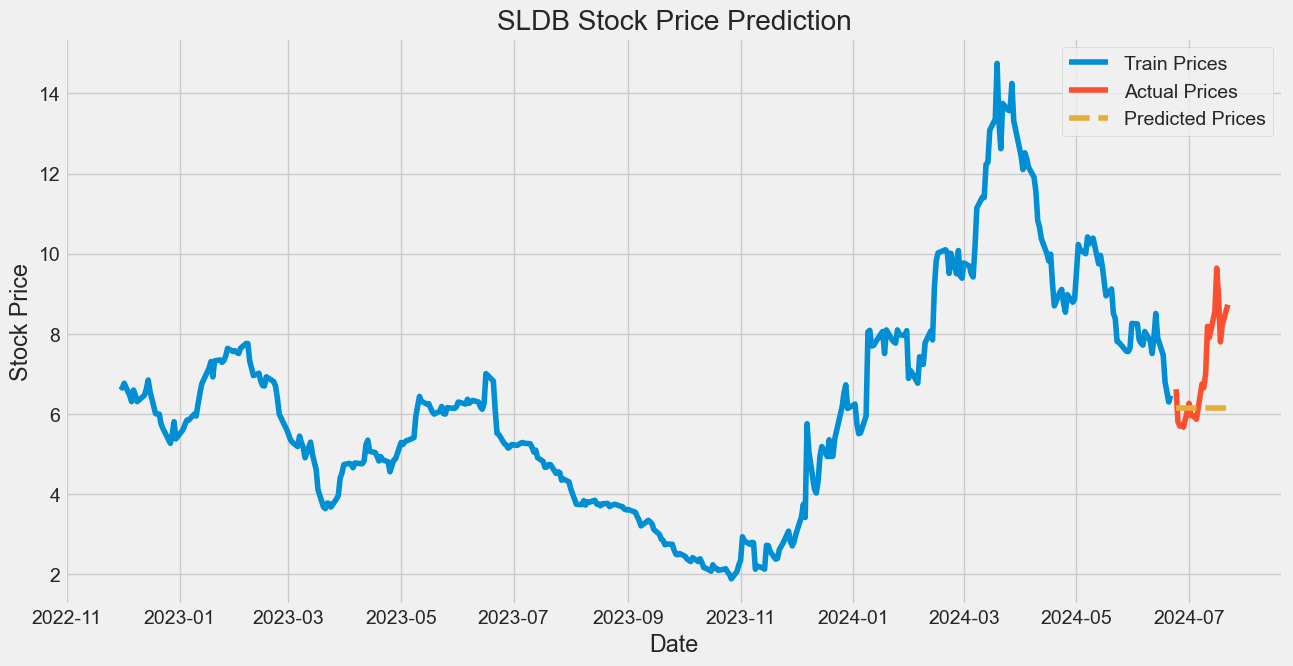

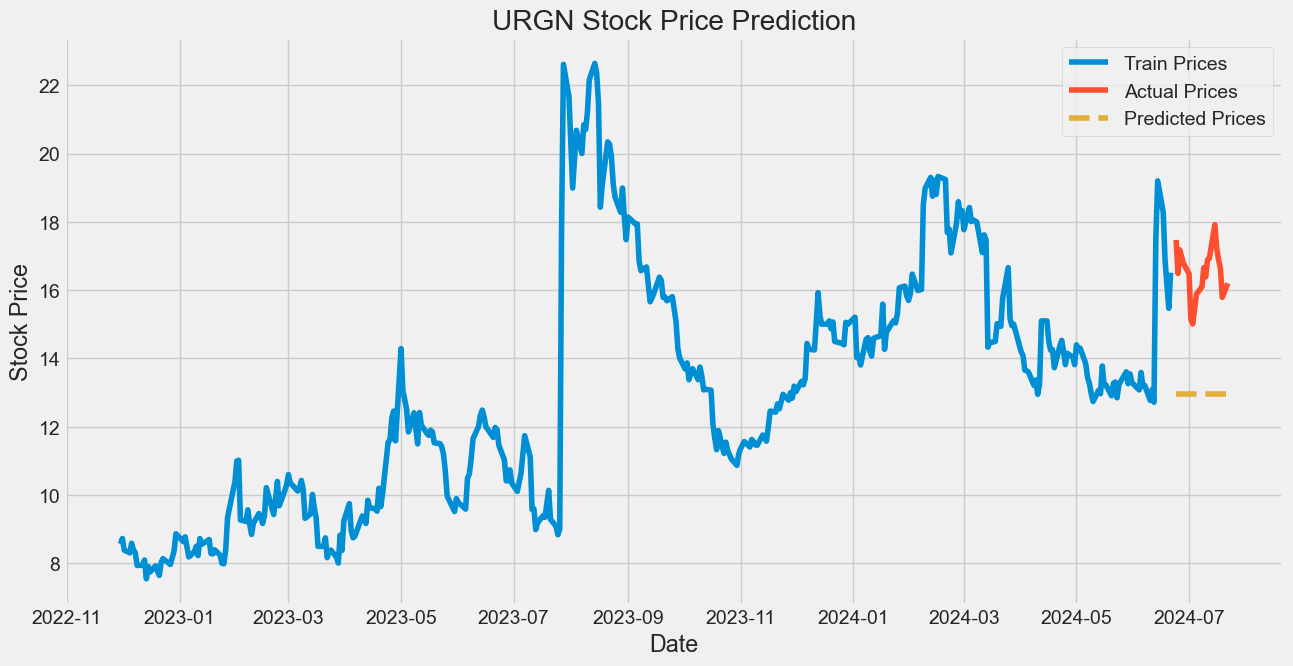

In [84]:
# Visualizing Dummy Regressor prediction.
def plot_predictions(model, y_train, X_test, y_test, stock):
    predictions = model.predict(X_test)
    plt.figure(figsize=(14, 7))
    plt.plot(y_train.index, y_train, label='Train Prices')
    plt.plot(y_test.index, y_test, label='Actual Prices')
    plt.plot(y_test.index, predictions, label='Predicted Prices', linestyle='--')
    plt.title(f"{stock} Stock Price Prediction")
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Plot predictions for the dummy regressor.
for stock in tech_list:
    X_train, X_test, y_train, y_test = split_data[stock]
    best_model = trained_models[stock]
    plot_predictions(best_model, y_train, X_test, y_test, stock)

### Modelling

### Machine Learning models

In [87]:
# function to split df into train and test.
def ml_preprocess_data(df):
    X = df.drop(columns=['company_name', 'ticker_symbol', 'Close'])
    y = df['Close']
     # Calculate the split index
    split_index = int(len(df) * train_split_percentage)
    
    # Split the data into training and test sets
    # IMPORTANT NOTE: Add a 1 row lag between X and Y. The goal is to predict next days Close Price using past data.
    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:-1]
    y_train = y.iloc[1:split_index+1]
    y_test = y.iloc[split_index+1:]
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

ml_processed_data = {}
for stock in tech_list:
    ml_processed_data[stock] = ml_preprocess_data(stock_data[stock])

In [89]:
# check to see shapes of train and test df and split correctly.
for i in range(4):
    print(ml_processed_data['OCUL'][i].shape)  #print(processed_data['OCUL'][i])

(391, 12)
(20, 12)
(391,)
(20,)


In [99]:
# Training Models function. We will explore Linear Regression, DecisionTree Regressor, and Random Forest Regressor.
def ml_train_models(X_train, y_train):
    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(n_estimators=100)
    }
    trained_models = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[model_name] = model
    return trained_models

ml_trained_models = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test = ml_processed_data[stock]
    ml_trained_models[stock] = ml_train_models(X_train, y_train)

In [101]:
def ml_evaluate_models(models, X_test, y_test):
    results = {}
    for model_name, model in models.items():
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        results[model_name] = {'MAE': mae, 'RMSE': rmse}
    return results

ml_evaluation_results = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test = ml_processed_data[stock]
    ml_evaluation_results[stock] = ml_evaluate_models(ml_trained_models[stock], X_test, y_test)

for stock, results in ml_evaluation_results.items():
    print(f"Evaluation results for {stock}:")
    for model_name, metrics in results.items():
        print(f"{model_name}: MAE = {metrics['MAE']}, RMSE = {metrics['RMSE']}")

Evaluation results for OCUL:
Linear Regression: MAE = 0.22085599627168656, RMSE = 0.2935228768394577
Decision Tree: MAE = 0.6419998883500001, RMSE = 0.9537241885766052
Random Forest: MAE = 0.24510500836100033, RMSE = 0.3360714796042931
Evaluation results for SLDB:
Linear Regression: MAE = 0.5039176756605449, RMSE = 0.6414390941007213
Decision Tree: MAE = 0.5875000235500001, RMSE = 0.8072515331580953
Random Forest: MAE = 0.5100324857870003, RMSE = 0.6711667005174863
Evaluation results for URGN:
Linear Regression: MAE = 0.5944971340738457, RMSE = 0.6800282927571376
Decision Tree: MAE = 1.22249999, RMSE = 1.4028808985620853
Random Forest: MAE = 0.7271649594600056, RMSE = 0.8642280010963664


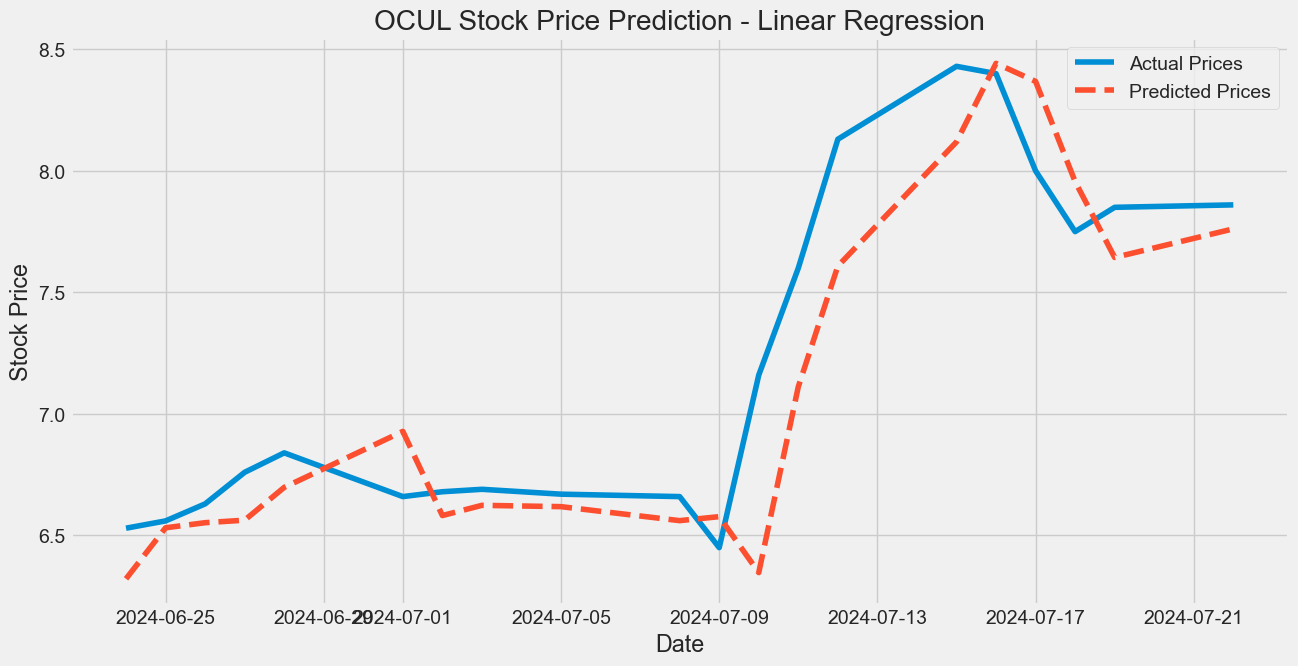

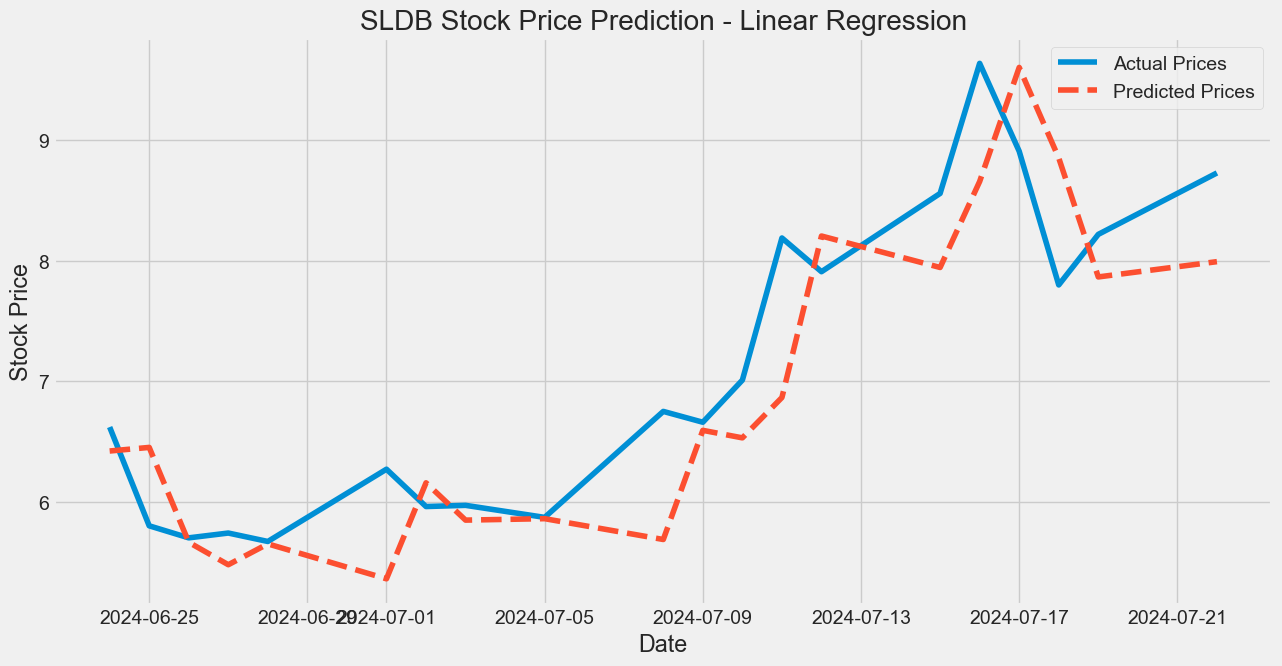

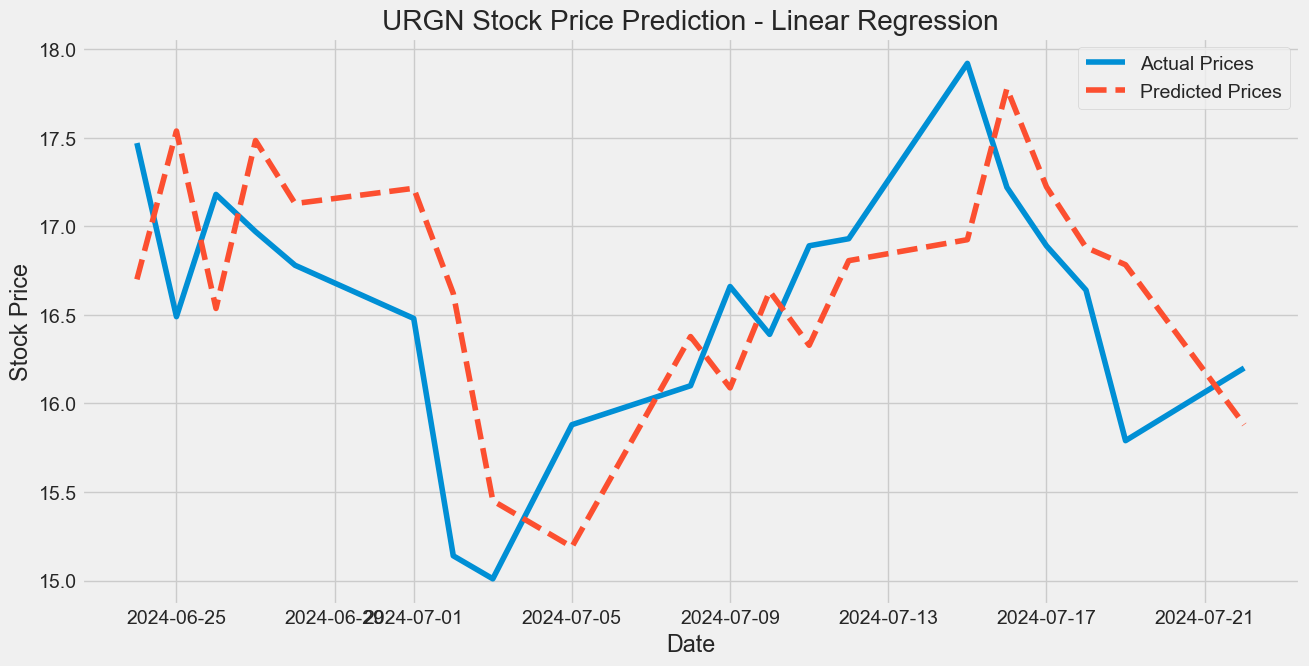

In [103]:
def ml_plot_predictions(model, y_train, X_test, y_test, stock):
    predictions = model.predict(X_test)
    #print(y_test, predictions)
    plt.figure(figsize=(14, 7))
    #plt.plot(y_train.index, y_train, label='Train Prices')
    plt.plot(y_test.index, y_test, label='Actual Prices')
    plt.plot(y_test.index, predictions, label='Predicted Prices', linestyle='--')
    plt.title(f"{stock} Stock Price Prediction - Linear Regression")
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Plot predictions for the best model (Random Forest in this example)
for stock in tech_list:
    X_train, X_test, y_train, y_test = ml_processed_data[stock]
    ml_best_model = ml_trained_models[stock]['Linear Regression']
    ml_plot_predictions(ml_best_model, y_train, X_test, y_test, stock)

### Deep Learning Models:

In [107]:
# Scale DataFrame:
def scale_data(df):
    scale_df = df.drop(columns=['company_name', 'ticker_symbol'])
    scaler = MinMaxScaler()
    # Fit and transform the data
    scaled_data = scaler.fit_transform(scale_df)
    # Convert the scaled data back to a DataFrame
    scaled_df = pd.DataFrame(scaled_data, columns=scale_df.columns)
    # Add the date index from lstm_df to scaled_df
    scaled_df.index = df.index
    print(scaled_df.shape)
    return scaled_df, scaler

scaled_data = {}
scalers = {}  # Store the scalers for each stock
for stock in tech_list:
    scaled_data[stock], scalers[stock] = scale_data(stock_data[stock])

(412, 13)
(412, 13)
(412, 13)


In [109]:
scaled_data['OCUL'].head()

,Open,High,Low,Adj Close,Volume,Daily_Return,30_MA,90_MA,RSI,MACD,actualEarningResult,estimatedEarning,Close
Date,,,,,,,,,,,,,
2022-11-29,0.088268,0.079121,0.094493,0.089266,0.016882,0.374469,0.126214,0.327704,0.342518,0.315651,1.0,1.0,0.089266
2022-11-30,0.083799,0.086813,0.096812,0.100565,0.011904,0.452604,0.120354,0.324243,0.527472,0.321000,1.0,1.0,0.100565
2022-12-01,0.096089,0.102198,0.111884,0.109605,0.009555,0.438931,0.116571,0.320863,0.458187,0.328667,1.0,1.0,0.109605
2022-12-02,0.096089,0.104396,0.110725,0.118644,0.009063,0.437710,0.113480,0.317322,0.365806,0.338064,1.0,1.0,0.118644
2022-12-05,0.115084,0.103297,0.104928,0.102825,0.014021,0.315016,0.110296,0.313808,0.263605,0.342147,1.0,1.0,0.102825


In [111]:
stock_data['OCUL'].head()

,ticker_symbol,company_name,Open,High,Low,Adj Close,Volume,Daily_Return,30_MA,90_MA,RSI,MACD,actualEarningResult,estimatedEarning,Close
Date,,,,,,,,,,,,,,,
2022-11-29,OCUL,OCUL,2.89,2.93,2.81,2.87,606900,-0.010345,3.361667,4.485056,40.645155,-0.270333,0.0,0.0,2.87
2022-11-30,OCUL,OCUL,2.85,3.00,2.83,2.97,472400,0.034843,3.319333,4.470722,57.031253,-0.256027,0.0,0.0,2.97
2022-12-01,OCUL,OCUL,2.96,3.14,2.96,3.05,408900,0.026936,3.292000,4.456722,50.892856,-0.235518,0.0,0.0,3.05
2022-12-02,OCUL,OCUL,2.96,3.16,2.95,3.13,395600,0.026230,3.269667,4.442056,42.708341,-0.210385,0.0,0.0,3.13
2022-12-05,OCUL,OCUL,3.13,3.15,2.90,2.99,529600,-0.044728,3.246667,4.427500,33.653853,-0.199464,0.0,0.0,2.99


In [113]:
def create_sequences(X_data, Y_data, seq_length):
    xs, ys = [], []
    for i in range(len(X_data) - seq_length):
        x = X_data[i:i + seq_length]
        y = Y_data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Function to split DataFrame into train and test sets
def preprocess_data(df, train_split_percentage=0.80, seq_length=3):
    # Split DataFrame into X and y
    X = df.drop(columns=['Close'])
    y = df['Close']
    
    # Retain the date index
    dates = df.index
    
    # Calculate the split index
    split_index = int(len(X) * train_split_percentage)
    
    # Split the data into training and test sets
    X_train = X.iloc[:split_index] 
    X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]   
    y_test = y.iloc[split_index:]
    dates_train = dates[:split_index]
    dates_test = dates[split_index:]

    print("Split data shape: ", "X_train: ", X_train.shape, "X_test: ", X_test.shape, "y_train: ", y_train.shape, "y_test: ", y_test.shape)
    
    # Create 3d array for LSTM module. needs to be set with sequence. 
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)
    
    dates_test_seq = dates_test[seq_length:]
    
    print("Sequence Split data shape: ", "X_train_seq: ", X_train_seq.shape, "X_test_seq: ", X_test_seq.shape, "y_train_seq: ", y_train_seq.shape, "y_test_seq: ", y_test_seq.shape)
    
    return X_train_seq, X_test_seq, y_train_seq, y_test_seq, dates_test_seq

processed_data = {}
for stock in tech_list:
    processed_data[stock] = preprocess_data(scaled_data[stock], train_split_percentage, seq_length)

Split data shape:  X_train:  (391, 12) X_test:  (21, 12) y_train:  (391,) y_test:  (21,)
Sequence Split data shape:  X_train_seq:  (361, 30, 12) X_test_seq:  (0,) y_train_seq:  (361,) y_test_seq:  (0,)
Split data shape:  X_train:  (391, 12) X_test:  (21, 12) y_train:  (391,) y_test:  (21,)
Sequence Split data shape:  X_train_seq:  (361, 30, 12) X_test_seq:  (0,) y_train_seq:  (361,) y_test_seq:  (0,)
Split data shape:  X_train:  (391, 12) X_test:  (21, 12) y_train:  (391,) y_test:  (21,)
Sequence Split data shape:  X_train_seq:  (361, 30, 12) X_test_seq:  (0,) y_train_seq:  (361,) y_test_seq:  (0,)


In [115]:
from sklearn.model_selection import TimeSeriesSplit

# Define the LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    return model

In [117]:
#Train LSTM models for each stock and store them in a dictionary
trained_models = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test, _ = processed_data[stock]
    model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
    X_train_tune = X_train[:int(len(X_train) * 0.9)]
    y_train_tune = y_train[:int(len(y_train) * 0.9)]
    X_val_tune = X_train[int(len(X_train) * 0.9):]
    y_val_tune = y_train[int(len(y_train) * 0.9):]
    model.fit(X_train, y_train, epochs=150, batch_size=256, validation_data=(X_val_tune, y_val_tune), verbose=2)
    trained_models[stock] = model

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 30, 50)              │          12,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,851 (128.32 KB)

 Trainable params: 32,851 (128.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
2/2 - 1s - 654ms/step - loss: 0.8380 - val_loss: 0.4141
Epoch 2/150
2/2 - 0s - 35ms/step - loss: 0.3789 - val_loss: 0.1344
Epoch 3/150
2/2 - 0s - 35ms/step - loss: 0.1367 - val_loss: 0.0135
Epoch 4/150
2/2 - 0s - 32ms/step - loss: 0.0423 - val_loss: 0.0235
Epoch 5/150
2/2 - 0s - 33ms/step - loss: 0.0591 - val_loss: 0.0595
Epoch 6/150
2/2 - 0s - 34ms/step - loss: 0.0838 - val_loss: 0.0417
Epoch 7/150
2/2 - 0s - 28ms/step - loss: 0.0622 - val_loss: 0.0137
Epoch 8/150
2/2 - 0s - 34ms/step - loss: 0.0351 - val_loss: 0.0040
Epoch 9/150
2/2 - 0s - 31ms/step - loss: 0.0255 - val_loss: 0.0098
Epoch 10/150
2/2 - 0s - 39ms/step - loss: 0.0225 - val_loss: 0.0200
Epoch 11/150
2/2 - 0s - 39ms/step - loss: 0.0270 - val_loss: 0.0270
Epoch 12/150
2/2 - 0s - 30ms/step - loss: 0.0288 - val_loss: 0.0277
Epoch 13/150
2/2 - 0s - 28ms/step - loss: 0.0257 - val_loss: 0.0229
Epoch 14/150
2/2 - 0s - 30ms/step - loss: 0.0220 - val_loss: 0.0156
Epoch 15/150
2/2 - 0s - 31ms/step - loss: 0.0166 - val_l

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 30, 50)              │          12,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,851 (128.32 KB)

 Trainable params: 32,851 (128.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
2/2 - 1s - 648ms/step - loss: 0.0476 - val_loss: 0.0308
Epoch 2/150
2/2 - 0s - 30ms/step - loss: 0.0230 - val_loss: 0.0037
Epoch 3/150
2/2 - 0s - 27ms/step - loss: 0.0153 - val_loss: 0.0053
Epoch 4/150
2/2 - 0s - 27ms/step - loss: 0.0109 - val_loss: 0.0101
Epoch 5/150
2/2 - 0s - 27ms/step - loss: 0.0131 - val_loss: 0.0035
Epoch 6/150
2/2 - 0s - 28ms/step - loss: 0.0100 - val_loss: 0.0038
Epoch 7/150
2/2 - 0s - 27ms/step - loss: 0.0092 - val_loss: 0.0044
Epoch 8/150
2/2 - 0s - 26ms/step - loss: 0.0078 - val_loss: 0.0066
Epoch 9/150
2/2 - 0s - 26ms/step - loss: 0.0079 - val_loss: 0.0061
Epoch 10/150
2/2 - 0s - 27ms/step - loss: 0.0071 - val_loss: 0.0049
Epoch 11/150
2/2 - 0s - 26ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 12/150
2/2 - 0s - 27ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 13/150
2/2 - 0s - 26ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 14/150
2/2 - 0s - 27ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 15/150
2/2 - 0s - 26ms/step - loss: 0.0056 - val_l

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 30, 50)              │          12,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,851 (128.32 KB)

 Trainable params: 32,851 (128.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
2/2 - 1s - 658ms/step - loss: 0.4649 - val_loss: 0.1624
Epoch 2/150
2/2 - 0s - 29ms/step - loss: 0.1282 - val_loss: 0.0100
Epoch 3/150
2/2 - 0s - 29ms/step - loss: 0.0456 - val_loss: 0.0628
Epoch 4/150
2/2 - 0s - 27ms/step - loss: 0.0859 - val_loss: 0.0702
Epoch 5/150
2/2 - 0s - 28ms/step - loss: 0.0799 - val_loss: 0.0327
Epoch 6/150
2/2 - 0s - 27ms/step - loss: 0.0412 - val_loss: 0.0117
Epoch 7/150
2/2 - 0s - 26ms/step - loss: 0.0257 - val_loss: 0.0117
Epoch 8/150
2/2 - 0s - 26ms/step - loss: 0.0287 - val_loss: 0.0182
Epoch 9/150
2/2 - 0s - 28ms/step - loss: 0.0350 - val_loss: 0.0205
Epoch 10/150
2/2 - 0s - 26ms/step - loss: 0.0367 - val_loss: 0.0174
Epoch 11/150
2/2 - 0s - 26ms/step - loss: 0.0330 - val_loss: 0.0125
Epoch 12/150
2/2 - 0s - 27ms/step - loss: 0.0252 - val_loss: 0.0098
Epoch 13/150
2/2 - 0s - 26ms/step - loss: 0.0200 - val_loss: 0.0113
Epoch 14/150
2/2 - 0s - 26ms/step - loss: 0.0193 - val_loss: 0.0154
Epoch 15/150
2/2 - 0s - 27ms/step - loss: 0.0205 - val_l

In [119]:
# Function to evaluate the model
def evaluate_models(model, X_test, y_test, scaler):
    y_pred = model.predict(X_test)

    # Inverse transform the predictions
    y_pred_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_pred), axis=1))[:, -1]
    original_ytest = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]

    mae = mean_absolute_error(original_ytest, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(original_ytest, y_pred_inv))
    return {'MAE': mae, 'RMSE': rmse}, y_pred_inv, original_ytest

# Function to plot y_pred vs y_test
def plot_predictions(dates, y_test, y_pred, stock_name):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_test, label='Actual')
    plt.plot(dates, y_pred, label='Predicted')
    plt.title(f'{stock_name} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

evaluation_results = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test, dates_test_seq = processed_data[stock]
    results, y_pred_inv, original_ytest = evaluate_models(trained_models[stock], X_test, y_test, scalers[stock])
    evaluation_results[stock] = results
    
    print(f"Evaluation results for {stock}:")
    print(f"MAE = {results['MAE']}, RMSE = {results['RMSE']}")
    
    # Plot predictions
    plot_predictions(dates_test_seq, original_ytest, y_pred_inv, stock)

ValueError: math domain error

In [121]:
!pip install keras-tuner --upgrade

In [123]:
import keras_tuner as kt

# Define a function to create the model with hyperparameters
def build_model(hp, input_shape):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units1', min_value=32, max_value=512, step=32),
                   return_sequences=True, input_shape=input_shape))
    model.add(Dropout(hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units2', min_value=32, max_value=512, step=32), return_sequences=False))
    model.add(Dropout(hp.Float('dropout2', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Apply the process only to the first stock in tech_list
first_stock = tech_list[0]
X_train, X_test, y_train, y_test, dates_test_seq = processed_data[first_stock]

# Set the input_shape variable
input_shape = (X_train.shape[1], X_train.shape[2])
  
# Create a tuner object with a lambda function to pass input_shape
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, input_shape),
    objective='val_loss',
    max_trials=1,  # Limit the number of trials to 1
    executions_per_trial=1,
    directory='my_dir',
    project_name=f'stock_price_prediction_{stock}'
)
    
X_train_tune = X_train[:int(len(X_train) * 0.9)]
y_train_tune = y_train[:int(len(y_train) * 0.9)]
X_val_tune = X_train[int(len(X_train) * 0.9):]
y_val_tune = y_train[int(len(y_train) * 0.9):]

tuner.search(X_train_tune, y_train_tune, epochs=100, validation_data=(X_val_tune, y_val_tune), verbose=1)
 
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
print(f"Optimal hyperparameters for {stock}:")
print(f"units1: {best_hps.get('units1')}")
print(f"dropout1: {best_hps.get('dropout1')}")
print(f"units2: {best_hps.get('units2')}")
print(f"dropout2: {best_hps.get('dropout2')}")

Reloading Tuner from my_dir\stock_price_prediction_OCUL\tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
64                |160               |units1
0.4               |0.1               |dropout1
288               |448               |units2
0                 |0.1               |dropout2


Epoch 1/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0978

Traceback (most recent call last):
  File "C:\Users\Sebastian\anaconda3\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Sebastian\anaconda3\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Sebastian\anaconda3\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Sebastian\anaconda3\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Us

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\Sebastian\anaconda3\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Sebastian\anaconda3\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Sebastian\anaconda3\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Sebastian\anaconda3\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Sebastian\anaconda3\Lib\site-packages\keras_tuner\src\engine\hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Sebastian\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Sebastian\anaconda3\Lib\site-packages\keras_tuner\src\engine\tuner_utils.py", line 76, in on_epoch_end
    self._save_model()
  File "C:\Users\Sebastian\anaconda3\Lib\site-packages\keras_tuner\src\engine\tuner_utils.py", line 86, in _save_model
    self.model.save_weights(write_filepath)
AttributeError: 'NoneType' object has no attribute 'File'


In [125]:
# Define the LSTM model
def best_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=160, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0))
    model.add(LSTM(units=256, return_sequences=False))
    model.add(Dropout(0.4))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    return model

#Train LSTM models for each stock and store them in a dictionary
best_trained_models = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test, _ = processed_data[stock]
    bmodel = best_model((X_train.shape[1], X_train.shape[2]))
    bmodel.fit(X_train, y_train, epochs=250, batch_size=64, verbose=0)
    best_trained_models[stock] = bmodel

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 30, 160)             │         110,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 160)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 256)                 │         427,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 537,985 (2.05 MB)

 Trainable params: 537,985 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 30, 160)             │         110,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 160)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 256)                 │         427,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 537,985 (2.05 MB)

 Trainable params: 537,985 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 30, 160)             │         110,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 160)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 256)                 │         427,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 537,985 (2.05 MB)

 Trainable params: 537,985 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [126]:
# Function to evaluate the model
def evaluate_models(model, X_test, y_test, scaler):
    y_pred = model.predict(X_test)

    # Inverse transform the predictions
    y_pred_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_pred), axis=1))[:, -1]
    original_ytest = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]

    mae = mean_absolute_error(original_ytest, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(original_ytest, y_pred_inv))
    return {'MAE': mae, 'RMSE': rmse}, y_pred_inv, original_ytest

# Function to plot y_pred vs y_test
def plot_predictions(dates, y_test, y_pred, stock_name):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_test, label='Actual')
    plt.plot(dates, y_pred, label='Predicted')
    plt.title(f'{stock_name} Stock Price Prediction with Best Model')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

evaluation_results = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test, dates_test_seq = processed_data[stock]
    results, y_pred_inv, original_ytest = evaluate_models(best_trained_models[stock], X_test, y_test, scalers[stock])
    evaluation_results[stock] = results
    
    print(f"Hypertuned Evaluation results for {stock}:")
    print(f"MAE = {results['MAE']}, RMSE = {results['RMSE']}")
    
    # Plot predictions
    plot_predictions(dates_test_seq, original_ytest, y_pred_inv, stock)

ValueError: math domain error

In [128]:
def plot_comparison(dates, y_test, y_pred, stock_name):
    plt.figure(figsize=(12, 6))
    plt.plot(dates[-15:], y_test[-15:], 'o-', label='Actual')
    plt.plot(dates[-15:], y_pred[-15:], 'o-', label='LSTM - Pred')
    plt.title(f'{stock_name} Stock Price Prediction Actual VS LSTM VS Linear (Last 15 Days)')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

evaluation_results = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test, dates_test_seq = processed_data[stock]
    results, y_pred_inv, original_ytest = evaluate_models(best_trained_models[stock], X_test, y_test, scalers[stock])
    evaluation_results[stock] = results
    
    print(f"Hypertuned Evaluation results for {stock}:")
    print(f"MAE = {results['MAE']}, RMSE = {results['RMSE']}")
    
    # Plot predictions for the last 15 days
    plot_comparison(dates_test_seq, original_ytest, y_pred_inv, stock)

ValueError: math domain error

In [130]:
def plot_comparison(dates, actual, lstm_pred, linear_pred, stock_name, lstm_metrics, linear_metrics):
    plt.figure(figsize=(12, 6))
    
    # Plot actual prices
    plt.plot(dates[-15:], actual[-15:], 'o-', label='Actual', color='blue')
    
    # Plot LSTM predicted prices
    plt.plot(dates[-15:], lstm_pred[-15:], 'o-', label='LSTM Predicted', color='green')
    
    # Plot Linear Regression predicted prices
    plt.plot(dates[-15:], linear_pred[-15:], 'o-', label='Linear Regression Predicted', color='red')
    
    plt.title(f'{stock_name} Stock Price Prediction Comparison (Last 15 Days)')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    
    # Display MAE and RMSE for both models
    plt.figtext(0.5, 0.01, f"LSTM - MAE: {lstm_metrics['MAE']:.2f}, RMSE: {lstm_metrics['RMSE']:.2f} | "
                           f"Linear Regression - MAE: {linear_metrics['MAE']:.2f}, RMSE: {linear_metrics['RMSE']:.2f}",
                ha="center", fontsize=12)
    
    plt.show()

# Evaluate the models
def ml_evaluate_models(models, X_test, y_test):
    results = {}
    for model_name, model in models.items():
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        results[model_name] = {'MAE': mae, 'RMSE': rmse}
    return results

# Evaluate the LSTM and Linear Regression models
evaluation_results = {}
ml_evaluation_results = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test, dates_test_seq = processed_data[stock]
    lstm_results, lstm_pred_inv, original_ytest = evaluate_models(best_trained_models[stock], X_test, y_test, scalers[stock])
    evaluation_results[stock] = lstm_results
    
    X_train_ml, X_test_ml, y_train_ml, y_test_ml = ml_processed_data[stock]
    ml_evaluation_results[stock] = ml_evaluate_models(ml_trained_models[stock], X_test_ml, y_test_ml)
    
    print(f"Hypertuned Evaluation results for {stock}:")
    print(f"LSTM - MAE = {lstm_results['MAE']}, RMSE = {lstm_results['RMSE']}")
    
    for model_name, metrics in ml_evaluation_results[stock].items():
        if model_name == 'Linear Regression':
            linear_metrics = metrics
            print(f"{model_name}: MAE = {metrics['MAE']}, RMSE = {metrics['RMSE']}")
    
    # Get Linear Regression predictions and metrics
    ml_best_model = ml_trained_models[stock]['Linear Regression']
    linear_predictions = ml_best_model.predict(X_test_ml)
    
    linear_metrics = ml_evaluation_results[stock]['Linear Regression']
    
    # Plot predictions for the last 15 days
    plot_predictions(dates_test_seq, original_ytest, lstm_pred_inv, linear_predictions, stock, lstm_results, linear_metrics)

ValueError: math domain error